<a href="https://colab.research.google.com/github/bondpy202212/AI_projects/blob/main/5_CNN_Tackle_Overfitting_with_Data_Augmentation(Cats_vs_Dogs_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Imports**

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

**Download the dataset**\
https://www.kaggle.com/c/dogs-vs-cats/data \
The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

In [2]:
!wget --no-check-certificate \
    -q "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"


**Unzip the dataset, /tmp/PetImages directory**

In [3]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

**Check out this catalog**

In [4]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


**Deletion of some photos from the catalog**

In [5]:
source_path = '/tmp/PetImages'
del_photo = 0.88
source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deleting some of the photos of the dogs
dog_images = os.listdir(source_path_dogs)
num_dog_images_to_delete = int(del_photo * len(dog_images))
images_to_delete = random.sample(dog_images, num_dog_images_to_delete)
for image in images_to_delete:
    os.remove(os.path.join(source_path_dogs, image))

# Deleting some of the photos of the cats
cat_images = os.listdir(source_path_cats)
num_cat_images_to_delete = int(del_photo * len(cat_images))
images_to_delete = random.sample(cat_images, num_cat_images_to_delete)
for image in images_to_delete:
    os.remove(os.path.join(source_path_cats, image))


**Check out this catalog**

In [6]:
# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 1500 images of dogs.
There are 1500 images of cats.


**Create a directory for cats-v-dogs, and subdirectories for training and validation.**

In [7]:
#  Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)


def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """

  path_tcats = root_dir + '/training/cats'
  os.makedirs(path_tcats)

  path_vcats = root_dir + '/validation/cats'
  os.makedirs(path_vcats)

  path_tdogs = root_dir + '/training/dogs'
  os.makedirs(path_tdogs)

  path_vdogs = root_dir + '/validation/dogs'
  os.makedirs(path_vdogs)


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

**Test "create_train_val_dirs" function**

In [8]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


**Divide the data into training and test sests**

In [9]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

  # Get a list of all files in the SOURCE_DIR
  files = os.listdir(SOURCE_DIR)
  # Remove files with zero length from consideration
  valid_files = [file for file in files if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0 ]
  for file in files:
    if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0:
      pass
    else:
      print(f"{file} is zero length, so ignoring.")

  # Randomly shuffle the list of valid files
  random.shuffle(valid_files)
  # Calculate the split index
  split_index = int(SPLIT_SIZE * len(valid_files))

  # Split the files into training and validation sets
  training_files = valid_files[:split_index]
  validation_files = valid_files[split_index:]

  # Copy files to the training directory
  for file in training_files:
      source_file = os.path.join(SOURCE_DIR, file)
      destination_file = os.path.join(TRAINING_DIR, file)
      shutil.copy(source_file, destination_file)

  # Copy files to the validation directory
  for file in validation_files:
      source_file = os.path.join(SOURCE_DIR, file)
      destination_file = os.path.join(VALIDATION_DIR, file)
      shutil.copy(source_file, destination_file)

**Test "split_data" function**

In [10]:
# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .67

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")



Original cat's directory has 1500 images
Original dog's directory has 1500 images

There are 1005 images of cats for training
There are 1005 images of dogs for training
There are 495 images of cats for validation
There are 495 images of dogs for validation


**Creates the training and validation data generators**

In [11]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator( rescale = 1.0 / 255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator( rescale = 1.0 / 255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

**Test the generators**

In [12]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 2010 images belonging to 2 classes.
Found 990 images belonging to 2 classes.


**Create a model to be trained.**

In [13]:
def create_model():

  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(150, 150, 3)),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

**Train the model**

In [ ]:
# Get the untrained model
model = create_model()

EPOCHS = 300

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100, # 2000 images = batch_size * steps
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=0)

**Visualize the loss and accuracy with respect to the training and validation set.**

In [16]:
def plot_loss_acc(history, text):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label= 'Validation_accuracy')
  plt.title(f'Training and validation accuracy({text})')
  plt.grid('True')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r-', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Valdation Loss')
  plt.title(f'Training and validation loss({text})')
  plt.grid('True')
  plt.legend()

  plt.show()

**Plot training results**

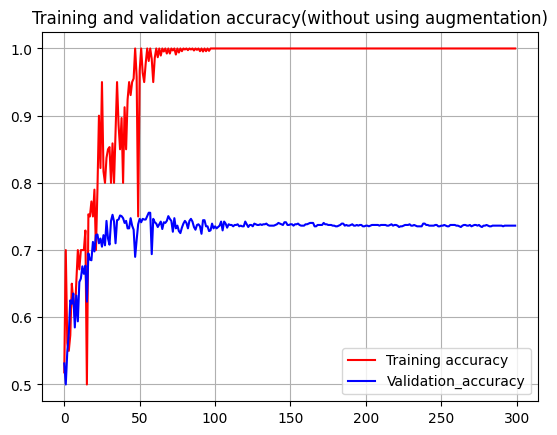

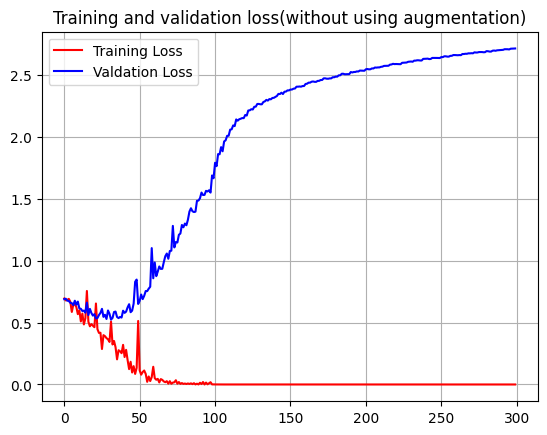

In [17]:
text_plot = "without using augmentation"
plot_loss_acc(history, text_plot)

**Using data augmentation**

In [ ]:
# Create new model
model_for_aug = create_model()

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

In [ ]:
# Train the new model
history_with_aug = model_for_aug.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      verbose=1)

**Plot the results of training with data augmentation**

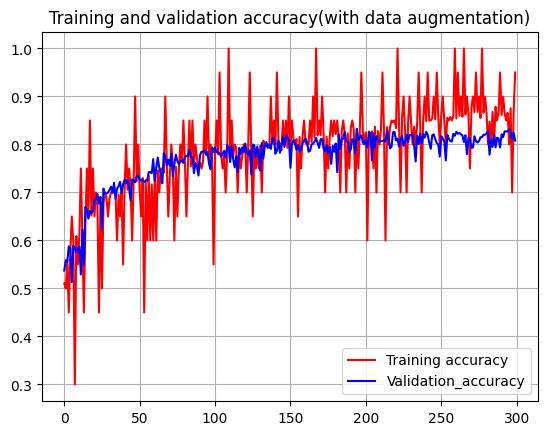

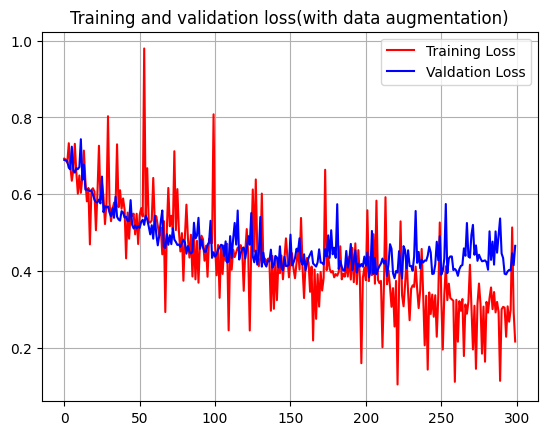

In [19]:
text_plot = "with data augmentation"
plot_loss_acc(history_with_aug, text_plot)